In [29]:
import os.path as path
import tarfile
from urllib.request import urlopen

from astropy.table import Table
from astropy.io import fits
from astropy.units import UnitsWarning
import warnings

import numpy as np
import numpy.core.defchararray as np_str
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.optimize import curve_fit

from tqdm import tnrange

################################################################################

# Downloads the FMOS and LEGA-C catalogues to the specified directories.
def download_data(fmos_dirname='fmos', legac_dirname='legac'):
    for url, dirname in [('http://member.ipmu.jp/fmos-cosmos/FC_spectra_files/'
                          '1dspec.tar.gz', fmos_dirname),
                         ('http://www2.mpia-hd.mpg.de/home/legac/dr2/'
                          'legac_dr2_spectra.tar.gz', legac_dirname)]:
        if not path.exists(dirname):
            ftpstream = urlopen(url)
            with tarfile.open(fileobj=ftpstream, mode='r|gz') as tar_file:
                tar_file.extractall(dirname)

################################################################################

# For every galaxy in the COSMOS2015 catalogue, record that galaxy's
# coordinates, its flux in every relevant filter, and the error in each flux.
# Correct the fluxes to account for aperture size and foreground extinction.
def load_phot_table(cosmos_filename='COSMOS2015_Laigle+_v1.1.fits'):
    # Read the entire COSMOS2015 catalog, ignoring the warning about poorly
    # formated units. The table is masked because there are missing values in
    # the ID_XMM, ID_CHANDRA09, and FLAG_XRAYBLEND columns; since those columns
    # are irrelevant, it can be converted to a regular table.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UnitsWarning)
        cosmos_table = Table.read(cosmos_filename).filled()
        
    # Ignore every object that is not a galaxy.
    cosmos_table.remove_rows(cosmos_table['TYPE'] != 0)
    
    # Ignore all masked galaxies.
    cosmos_table.remove_rows(cosmos_table['FLAG_PETER'] != 0)
    
    # Record the name of each filter, its description in the COSMOS2015
    # catalogue header, and its systematic offset and foreground extinction
    # factor (from columns 4 and 5 of Table 3 in the COSMOS2015 paper,
    # https://arxiv.org/pdf/1604.02350.pdf).
    filter_data = [('yHSC',      'Optical/NIR', -0.014, 1.298),
                   ('Y',         'Optical/NIR',  0.001, 1.211),
                   ('J',         'Optical/NIR',  0.017, 0.871),
                   ('H',         'Optical/NIR',  0.055, 0.563),
                   ('Ks',        'Optical/NIR', -0.001, 0.364),
                   ('Ksw',       'Optical/NIR',  0.068, 0.364),
                   ('Hw',        'Optical/NIR', -0.031, 0.563),
                   ('u',         'Optical/NIR',  0.010, 4.660),
                   ('B',         'Optical/NIR',  0.146, 4.020),
                   ('V',         'Optical/NIR', -0.117, 3.117),
                   ('r',         'Optical/NIR', -0.012, 2.660),
                   ('ip',        'Optical/NIR',  0.020, 1.991),
                   ('zpp',       'Optical/NIR', -0.084, 1.461),
                   ('IB427',     'Optical/NIR',  0.050, 4.260),
                   ('IB464',     'Optical/NIR', -0.014, 3.843),
                   ('IA484',     'Optical/NIR', -0.002, 3.621),
                   ('IB505',     'Optical/NIR', -0.013, 3.425),
                   ('IA527',     'Optical/NIR',  0.025, 3.264),
                   ('IB574',     'Optical/NIR',  0.065, 2.937),
                   ('IA624',     'Optical/NIR', -0.010, 2.694),
                   ('IA679',     'Optical/NIR', -0.194, 2.430),
                   ('IA738',     'Optical/NIR',  0.017, 2.289),
                   ('IA767',     'Optical/NIR',  0.020, 2.150),
                   ('IB709',     'Optical/NIR',  0.024, 1.996),
                   ('IB827',     'Optical/NIR', -0.005, 1.747),
                   ('NB711',     'Optical/NIR',  0.040, 2.268),
                   ('NB816',     'Optical/NIR', -0.035, 1.787),
                   ('SPLASH_1',  'IRAC',        -0.025, 0.162),
                   ('SPLASH_2',  'IRAC',        -0.005, 0.111),
                   ('SPLASH_3',  'IRAC',        -0.061, 0.075),
                   ('SPLASH_4',  'IRAC',        -0.025, 0.045),
                   ('GALEX_NUV', 'Other',        0.128, 8.621)]
    
    # Create a list for the columns of the photometric data table, along with a
    # list for their names. Initialize both lists with the coordinates of each
    # galaxy.
    colnames = ['ra', 'dec']
    columns = [cosmos_table['ALPHA_J2000'], cosmos_table['DELTA_J2000']]
    
    for name, description, offset, factor in filter_data:
        # Determine the name of the column in the COSMOS2015 catalogue that
        # contains the fluxes for this filter, along with the name of the column
        # that contains the errors for those fluxes.
        if description == 'Optical/NIR':
            flux_colname = name + '_FLUX_APER3'
            error_colname = name + '_FLUXERR_APER3'
        elif description == 'IRAC':
            flux_colname =  name + '_FLUX'
            error_colname = name + '_FLUX_ERR'
        else:
            flux_colname = 'FLUX_' + name
            error_colname = 'FLUXERR_' + name
        
        # Calculate the correction factor for this filter. As specified in the
        # appendix of the COSMOS2015 paper, the AB magnitude m for an object
        # with photometric offset o and reddenning value EBV that is measured
        # through a filter with systematic offset s and extinction factor F
        # should be corrected to m - s + o - F * EBV. Combining this with the
        # fact that any flux f can be expressed in terms of the corresponding AB
        # magnitude m as 10^(-0.4 * (m + 48.6)) gives us the correction factor.
        correction = 10.0 ** (0.4 * (offset - cosmos_table['OFFSET'] +
                                     factor * cosmos_table['EBV']))
        
        # Add the corrected fluxes and errors to the list of columns, and update
        # the list of column names accordingly.
        columns.append(cosmos_table[flux_colname] * correction)
        columns.append(cosmos_table[error_colname] * correction)
        colnames.append(name)
        colnames.append(name + '_ERR')

    # Convert all the columns into a single table.
    return Table(columns, names=colnames)

################################################################################

# For every spectrum file, load the name of the catalogue that led to the file
# and the path to the file (either a url or a file system path). Additionally,
# load the coordinates and spectroscopic redshift of the galaxy associated with
# each spectrum. If bad redshifts should be ignored, spectra with unknown or 0
# redshifts are not included; otherwise, every unknown redshift is denoted by
# NaN. If the zCOSMOS-bright catalogue is available, those spectra are inclued.
# Similarly, if the directories containing the FMOS, LEGA-C, zCOSMOS-deep
# spectra are available, those spectra are also included.
def load_spec_table(zbright_catalogue_path=None, fmos_dirname=None,
                    legac_dirname=None, zdeep_dirname=None, ignore_bad_zs=True):
    names = []
    paths = []
    ras = []
    decs = []
    zs = []
    
    # Record the data from a particular catalogue.
    def add_data(catalogue_name, catalogue_table,
                 path_list, ra_colname, dec_colname,
                 path_fun=None, ra_fun=None, dec_fun=None,
                 z_colname=None, unknown_z_value=None, unknown_z_value2=None,
                 star_colname=None, star_value=None, star_substr=None):
        # Remove all stars from the catalogue if they are indicated in some
        # column. Either compare the values in that column to some value, or
        # search the strings in that column for some substring.
        if star_colname:
            star_col = catalogue_table[star_colname]
            if star_substr:
                is_star = np_str.find(np_str.lower(star_col), star_substr) != -1
            else:
                is_star = star_col == star_value
            catalogue_table.remove_rows(is_star)

        # Record the redshifts from the catalogue, if they are indicated in some
        # column. Otherwise, use NaN for every redshift.
        if z_colname:
            # If unknown redshifts are indicated by some value, either remove
            # all rows with unknown redshifts, or replace every unknown redshift
            # with NaN, depending on whether bad redshifts should be ignored. If
            # the redshifts weren't already floating-point values, convert them.
            if unknown_z_value:
                z_col = catalogue_table[z_colname]
                if (ignore_bad_zs and z_col.dtype.kind == 'f' and
                    np.isnan(unknown_z_value)):
                    catalogue_table.remove_rows(np.isnan(z_col))
                else:
                    unknown_zs = z_col == unknown_z_value
                    if unknown_z_value2:
                        unknown_zs = np.logical_or(unknown_zs,
                                                   z_col == unknown_z_value2)
                    if ignore_bad_zs:
                        catalogue_table.remove_rows(unknown_zs)
                    else:
                        z_col[unknown_zs] = z_col.dtype.type(np.nan)
                    if z_col.dtype.kind != 'f':
                        float_z_col = catalogue_table[z_colname].astype('f')
                        catalogue_table.replace_column(z_colname, float_z_col)

            # If bad redshifts should be ignored, remove all rows with 0
            # redshifts.
            if ignore_bad_zs:
                zero_zs = catalogue_table[z_colname] == 0
                catalogue_table.remove_rows(zero_zs)

            new_zs = catalogue_table[z_colname]
        else:
            new_zs = np.full(len(catalogue_table), np.nan)

        # Record the paths to the spectra from the catalogue. For each string in
        # the path list, if the string is the name of a column, add the strings
        # in that column to the paths, optionally applying a function to each
        # string. Otherwise, just add the string to each path.
        new_paths = np.full(len(catalogue_table), '')
        for string in path_list:
            if string in catalogue_table.colnames:
                path_col = catalogue_table[string].astype('U')
                if path_fun:
                    path_col = np.vectorize(path_fun)(path_col)
                new_paths = np_str.add(new_paths, path_col)
            else:
                new_paths = np_str.add(new_paths, string)

        # Record the coordinates from the catalogue, optionally applying a
        # function to each coordinate.
        new_ras = catalogue_table[ra_colname]
        new_decs = catalogue_table[dec_colname]
        if ra_fun:
            new_ras = np.vectorize(ra_fun)(new_ras)
        if dec_fun:
            new_decs = np.vectorize(dec_fun)(new_decs)

        # Add all the recorded information to the given lists.
        names.append(np.full(len(catalogue_table), catalogue_name))
        paths.append(new_paths)
        ras.append(new_ras)
        decs.append(new_decs)
        zs.append(new_zs)
    
    #-----------------------------------IPAC-----------------------------------#
    
    # Record the url that will be prepended to every IPAC path.
    ipac_url = 'https://irsa.ipac.caltech.edu/data/COSMOS/'
    
    # Load the DEIMOS catalogue.
    deimos_catalogue = Table.read(ipac_url +
                              'tables/spectra/deimos_redshift_linksIRSA.tbl',
                              format='ipac')
    
    # Ignore all rows without paths to the associated spectra.
    deimos_catalogue.remove_rows(deimos_catalogue['ascii1d'].mask)

    # Since some paths were missing, the table is masked. Convert the
    # masked table to a regular table.
    deimos_catalogue = deimos_catalogue.filled()
    
    # Add the data from the DEIMOS catalogue.
    add_data('DEIMOS', deimos_catalogue, [ipac_url, 'fits1d'], 'ra', 'dec',
             path_fun=lambda s: s.split('"')[1][13:], z_colname='zspec',
             unknown_z_value='NA', star_colname='Remarks', star_substr='star')
    
    # Add the data from the Magellan catalogue.
    add_data('Magellan',
             Table.read(ipac_url + 'tables/spectra/magellan_opt_spec_30.tbl',
                        format='ipac'),
             [ipac_url, 'FITS_u'], 'ra', 'dec', z_colname='redshift',
             unknown_z_value=-1, star_colname='class', star_value='star')
    
    if zbright_catalogue_path:
        # Add the data from the zCOSMOS-bright catalogue, which does not
        # indicate stars.
        add_data('zCOSMOS-bright', Table.read(zbright_catalogue_path),
                 [ipac_url + 'spectra/z-cosmos/DR3/', 'FILENAME'],
                 'RAJ2000', 'DEJ2000', z_colname='REDSHIFT',
                 unknown_z_value=np.nan)
        
    #-----------------------------------C3R2-----------------------------------#
        
    # Converts a string of the form hh:mm:ss to degrees.
    def ra_to_deg(s):
        return 15 * float(s[0:2]) + float(s[3:5]) / 4 + float(s[6:]) / 240

    # Converts a string of the form (+/-)dd:mm:ss to degrees.
    def dec_to_deg(s):
        if s[0] == '+':
            return float(s[1:3]) + float(s[4:6]) / 60 + float(s[7:]) / 3600
        elif s[0] == '-':
            return -float(s[1:3]) - float(s[4:6]) / 60 - float(s[7:]) / 3600
        else:
            return float(s[0:2]) + float(s[3:5]) / 60 + float(s[6:]) / 3600
    
    # Record the url that will be prepended to every C3R2 path.
    c3r2_url = 'https://koa.ipac.caltech.edu/data/Contributed/C3R2/'
    
    # Add the data from the C3R2 catalogue, which does not indicate unknown
    # redshifts or stars, and which does not come with column names.
    add_data('C3R2',
             Table.read(c3r2_url + 'c3r2_targets_2019mar28.txt', data_start=17,
                        format='ascii.no_header'),
             [c3r2_url + 'spec1d/', 'col10'], 'col2', 'col3',
             ra_fun=ra_to_deg, dec_fun=dec_to_deg, z_colname='col7')
    
    #-----------------------------------FMOS-----------------------------------#
    
    if fmos_dirname:
        # Record the first part of the path list for every FMOS path.
        fmos_path_list = [path.join(fmos_dirname, '1dspec', ''), 'FMOS_ID', '_']

        # Load the FMOS catalogue.
        fmos_catalogue = Table.read('http://member.ipmu.jp/fmos-cosmos/'
                                    'FC_catalogs_files/FMOS_COSMOS_v1.0.fits')

        # Add the data for H-Long spectra from the FMOS catalogue.
        add_data('FMOS', fmos_catalogue,
                 fmos_path_list + ['DATE_OBS_HL', '_hl_1d.fits'], 'RA', 'DEC',
                 z_colname='ZSPEC', unknown_z_value=-999,
                 star_colname='TYPE', star_value=1)

        # Ignore all rows that do not have associated J-Long spectra.
        fmos_catalogue.remove_rows(fmos_catalogue['OBS_JL'] == 0)

        # Add the data for J-Long spectra from the FMOS catalogue. Since all the
        # stars were already removed and all the bad redshifts were already
        # removed/replaced, there is no need to pass that information again.
        add_data('FMOS', fmos_catalogue,
                 fmos_path_list + ['DATE_OBS_JL', '_jl_1d.fits'], 'RA', 'DEC',
                 z_colname='ZSPEC')
    
    #----------------------------------LEGA-C----------------------------------#
    
    if legac_dirname:
        # Add the data from the LEGA-C catalogue, which does not indicate stars.
        add_data('LEGA-C',
                 Table.read('http://www.mpia.de/home/legac/dr2/'
                            'legac_dr2_cat.fits.gz'),
                 [path.join(legac_dirname, 'spectraDR', ''), 'Filename'],
                 'RAJ2000', 'DECJ2000', path_fun=lambda s: s.rstrip(' '),
                 z_colname='z', unknown_z_value=np.nan)
    
    #-------------------------------ZCOSMOS-DEEP-------------------------------#
    
    if zdeep_dirname:
        # Add the data from the zCOSMOS-deep catalogue, which does not indicate
        # stars.
        add_data('zCOSMOS-deep',
                 Table.read(path.join(zdeep_dirname, 'catalogs', 'DEEP_zcosmos_'
                                      'spectroscopy_one_v2.6.data'),
                            format='ascii'),
                 [path.join(zdeep_dirname, 'spectra', 'LB'), 'pointing',
                  path.join(path.sep + '1DFiles', 'sc_000'), 'id', '_ZCLBa',
                  'pointing', '_M1_blue_', 'slit', '_', 'obj',
                  '_cal_clean.fits'],
                 'ra', 'dec', z_colname='zspec', unknown_z_value=9.9999,
                 unknown_z_value2=9.999)
    
    #--------------------------------------------------------------------------#
    
    # Convert all the gathered data into a single table.
    return Table(list(map(np.concatenate, (names, paths, ras, decs, zs))),
                 names=('name', 'path', 'ra', 'dec', 'z'))

################################################################################

# Given two arrays that specify points (x1, y1) and two arrays that specify
# points (x2, y2), find all pairs of indices (index1, index2) for which the
# point (x1, y1) at index1 and the point (x2, y2) at index2 have coordinates
# such that abs(x1 - x2) and abs(y1 - y2) are less than the specified tolerance
# tol. If duplicates are not allowed, only the closest matches for (x1, y1) are
# selected; i.e., if (x1, y1) and (x2, y2) are selected, there is no other point
# (x2, y2) that is closer to (x1, y1).
def find_matches(x_array1, y_array1, x_array2, y_array2, tol,
                 allow_duplicates=False):
    # Get the lengths of the x-arrays (which are the same as the lengths of the
    # corresponding y-arrays).
    length1 = len(x_array1)
    length2 = len(x_array2)
    
    # Get the indices that sort the x-arrays and use them to sort the arrays.
    sorting_indices1 = np.argsort(x_array1)
    sorting_indices2 = np.argsort(x_array2)
    sorted_x_array1 = x_array1[sorting_indices1]
    sorted_x_array2 = x_array2[sorting_indices2]
    
    if allow_duplicates:
        # Initialize two lists of matching indices.
        matching_indices1 = []
        matching_indices2 = []
        
    else:
        # Initialize dictionaries that map the incides of points (x1, y1) to
        # their closest matches (x2, y2) and to the distances to those matches.
        index1_to_index2 = {}
        index1_to_dist = {}
    
    # Iterate through the sorted x-arrays, looking for two x-coordinates x1 and
    # x2 within tol of each other. When two such x-coordinates are found, check
    # whether the corresponding y-coordinates y1 and y2 are also within tol of
    # each other.
    sorted_index2 = 0
    for sorted_index1 in tnrange(length1, leave=False, smoothing=0.05,
                                 bar_format=
                                 '{n}/|/Estimated Time Remaining: {remaining}'):
        # Get x1, the x-coordinate at the current index in the first sorted
        # x-array.
        x1 = sorted_x_array1[sorted_index1]

        # Iterate through the second sorted x-array until x1 < x2' + tol, where
        # x2' is the x-coordinate at the current index in the second sorted
        # x-array.
        while (sorted_index2 < length2 and
               x1 >= sorted_x_array2[sorted_index2] + tol):
            sorted_index2 += 1
            
        # If the end of the second sorted x-array has been reached, no more
        # matching indices will be found, since all the remaining values of
        # x1 are at least as large as the current value, and the current value
        # satisfies x1 >= x2' + tol.
        if sorted_index2 == length2:
            break

        # Iterate through the second sorted x-array while x1 > x2 - tol, where
        # x2 is an x-coordinate at or after the current index in the second
        # sorted x-array. Since x2 >= x2' and x1 < x2' + tol, it must be the
        # case that x1 < x2 + tol. Therefore, x1 and x2 are within tol of each
        # other when x1 > x2 - tol.
        temp_sorted_index2 = sorted_index2
        while x1 > sorted_x_array2[temp_sorted_index2] - tol:
            # Get the indices of x1 and x2 in the original (unsorted) x-arrays.
            index1 = sorting_indices1[sorted_index1]
            index2 = sorting_indices2[temp_sorted_index2]
            
            # Get the y-coordinates y1 and y2 that correspond to x1 and x2.
            y1 = y_array1[index1]
            y2 = y_array2[index2]
            
            # Check whether y1 and y2 are also within tol of each other.
            if y1 < y2 + tol and y1 > y2 - tol:
                if allow_duplicates:
                    matching_indices1.append(index1)
                    matching_indices2.append(index2)
                
                else:
                    x2 = sorted_x_array2[temp_sorted_index2]
                    dist = np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

                    # If there is no closer match for (x1, y1), update the
                    # dictionaries.
                    if (index1 not in index1_to_dist or
                        dist < index1_to_dist[index1]):
                        index1_to_dist[index1] = dist
                        index1_to_index2[index1] = index2
            
            temp_sorted_index2 += 1
            if temp_sorted_index2 == length2:
                break
    
    # Return the closest matches as two arrays, with each index1 in the
    # first array and each corresponding index2 in the second array.
    if allow_duplicates:
        return matching_indices1, matching_indices2
    else:
        return (np.array(list(index1_to_index2.keys())),
                np.array(list(index1_to_index2.values())))

################################################################################

# Given the spectroscopic table, determine errors for the zCOSMOS-bright spectra
# by interpolating/axtrapolating the median errors of the LEGA-C spectra, since
# both were measured with the same instrument.
def get_zbright_errors(spec_table):
    # Load the parts of the spectroscopic table related to each catalogue.
    legac_table = spec_table[spec_table['name'] == 'LEGA-C']
    zbright_table = spec_table[spec_table['name'] == 'zCOSMOS-bright']
    
    # Record the wavelengths used in each catalogue by looking at the first
    # spectrum in each catalogue.
    with fits.open(legac_table['path'][0]) as hdus:
        legac_wavelengths = hdus[1].data[0][0]
    with fits.open(zbright_table['path'][0]) as hdus:
        zbright_wavelengths = hdus[1].data[0][0]
        
    # Record all of the errors in the LEGA-C catalogue. This may take some time.
    errors = np.zeros((len(legac_wavelengths), len(legac_table)))
    for spectrum_num in tnrange(len(legac_table), leave=False, smoothing=0.05,
                                bar_format=
                                '{n}/|/Estimated Time Remaining: {remaining}'):
        with fits.open(legac_table['path'][spectrum_num]) as hdus:
            errors[:, spectrum_num] = hdus[1].data[0][2]
    
    # An unknown error is denoted by either 0 or NaN. Convert every 0 to an NaN.
    errors = np.where(errors == 0, np.nan, errors)
    
    # The distribution of errors at every wavelength is quite erratic, with
    # a few values on the order of 1e5 interspersed among values on the order of
    # 10. If the mean of the errors at every wavelength is calculated, the large
    # values dominate the mean, even though they do not convey much information.
    # Therefore, the median of the errors should be calculated instead of the
    # mean. Furthermore, there are a lot of unknown errors at very short and
    # very long wavelengths, which causes the median errors at those wavelengths
    # to oscillate chaotically. This can be avoided by only using wavelengths at
    # which a sufficient number of errors are known.
    is_enough_known = np.sum(np.isfinite(errors), axis=1) >= 100
    legac_wavelengths = legac_wavelengths[is_enough_known]
    median_errors = np.nanmedian(errors[is_enough_known], axis=1)
        
    # Record the indices that separate the zCOSMOS-bright wavelengths that
    # overlap with the remaining LEGA-C wavelengths from those that do not.
    index1 = np.argmax(zbright_wavelengths >= legac_wavelengths[0])
    index2 = np.argmax(zbright_wavelengths >= legac_wavelengths[-1])
    
    # Interpolate the median errors to the zCOSMOS-bright wavelengths that
    # overlap with the LEGA-C wavelengths.
    interpolation = interp1d(legac_wavelengths, median_errors)
    interp_errors = interpolation(zbright_wavelengths[index1:index2])
    
    # Extrapolate the median errors to the zCOSMOS-bright wavelengths that do
    # not overlap with the LEGA-C wavelengths. In order to improve the
    # extrapolation, use a median filter to remove the effects of atmosphereic
    # emission/absorption lines from the errors, leaving behind just the effects
    # of the instrumentation. Then, fit the sum of two exponentials and a
    # constant to the filtered errors at short and long wavelengths, and
    # evaluate the fitted function at the non-overlapping wavelengths.
    def fitting_fun(x, a1, b1, a2, b2, c):
        return a1 * np.exp(b1 * x) + a2 * np.exp(b2 * x) + c
    num_to_fit = 700
    fitting_wavelengths = np.concatenate((legac_wavelengths[:num_to_fit],
                                          legac_wavelengths[-num_to_fit:]))
    filtered_errors = medfilt(median_errors, 81)
    fitting_errors = np.concatenate((filtered_errors[:num_to_fit],
                                     filtered_errors[-num_to_fit:]))
    params = curve_fit(fitting_fun, fitting_wavelengths, fitting_errors,
                       p0=(1e18, -1e-3, 1e-30, 1e-2, 1), maxfev=100000)[0]
    extrap_errors1 = fitting_fun(zbright_wavelengths[:index1], *params)
    extrap_errors2 = fitting_fun(zbright_wavelengths[index2:], *params)
    
    # Combine the interpolated and extrapolated errors.
    return np.concatenate((extrap_errors1, interp_errors, extrap_errors2))

# Given the name of a catalogue and the path to a spectrum file (in FITS format)
# from that catalogue, return an array of wavelengths (in Angstroms), an array
# of corresponding fluxes (in arbitrary units), and an array of errors on those
# fluxes. Ignore all 0 fluxes, and ignore all fluxes with errors of 0 or NaN. If
# the file records flux errors, the errors may be scaled so that their average
# is the standard deviation of the flux noise. Otherwise, downsample the fluxes
# into bins with the given number of wavelengths, and use the standard devaition
# of each bin as its error. Although zCOSMOS-bright files do not record flux
# errors, an array of appropriate errors may be passed.
def read_spec_file(name, path, zbright_errors=None, scale_errors=False,
                   wavelengths_per_bin=5):
    with fits.open(path) as hdus:
        if name == 'zCOSMOS-bright':
            wavelengths = hdus[1].data['WAVE'][0]
            fluxes = hdus[1].data['FLUX_REDUCED'][0]
            errors = zbright_errors
        elif name == 'DEIMOS' or name == 'C3R2':
            inverse_variances = hdus[1].data['IVAR'][0]
            is_nonzero = inverse_variances != 0
            wavelengths = hdus[1].data['LAMBDA'][0][is_nonzero]
            fluxes = hdus[1].data['FLUX'][0][is_nonzero]
            errors = np.reciprocal(np.sqrt(inverse_variances[is_nonzero]))
        elif name == 'LEGA-C':
            errors = hdus[1].data['ERR'][0]
            is_nonzero = np.logical_and(np.isfinite(errors), errors != 0)
            wavelengths = hdus[1].data['WAVE'][0][is_nonzero]
            fluxes = hdus[1].data['FLUX'][0][is_nonzero]
            errors = errors[is_nonzero]
        elif name == 'Magellan':
            fluxes = hdus[0].data[1]
            is_nonzero = fluxes != 0
            wavelengths = hdus[0].data[0][is_nonzero]
            fluxes = fluxes[is_nonzero]
            errors = hdus[0].data[2][is_nonzero]
        
        # The spectrum files from the remaining catalogues do not record flux
        # errors. While they also do not record all the wavelengths, they do
        # record the smallest wavelength, the difference between consecutive
        # wavelengths, and the total number of wavelengths, which can be used to
        # reconstruct all the wavelengths.
        else:
            head = hdus[0].header
            errors = None
            if name == 'zCOSMOS-deep':
                wavelengths = (head['CRVAL1'] +
                               head['CDELT1'] * np.arange(head['NAXIS1']))
                fluxes = hdus[0].data[0]
            elif name == 'FMOS':
                fluxes = hdus[0].data
                is_nonzero = fluxes != 0
                wavelengths = (head['CRVAL1'] +
                               head['CD1_1'] * np.arange(head['NAXIS1']))
                wavelengths = wavelengths[is_nonzero]
                fluxes = fluxes[is_nonzero]
            
            # There are no other catalogue names, so the given name is wrong.
            else:
                raise ValueError('Invalid catalogue name')
    
    # If there are no errors, downsample the fluxes into bins that each contain
    # wavelengths_per_bin wavelengths, and then obtain errors for each of the
    # bins. Otherwise, if necessary, scale the errors so that their average
    # coincides with the standard deviation of the difference between the actual
    # fluxes and the background fluxes (obtained by applying a median filter).
    if errors is None:
        truncated_length = wavelengths_per_bin * int(len(wavelengths) /
                                                     wavelengths_per_bin)
        bins = wavelengths[:truncated_length].reshape(-1, wavelengths_per_bin)
        bin_fluxes = fluxes[:truncated_length].reshape(-1, wavelengths_per_bin)
        wavelengths = np.mean(bins, axis=1)
        fluxes = np.mean(bin_fluxes, axis=1)
        errors = np.std(bin_fluxes, axis=1)
    elif scale_errors:
        errors *= np.std(fluxes - medfilt(fluxes, 81)) / np.mean(errors)
        
    return (wavelengths, fluxes, errors)

In [2]:
phot_table = load_phot_table()
spec_table = load_spec_table('zCOSMOS_VIMOS_BRIGHT_DR3_CATALOGUE.fits',
                             'FMOS', 'LEGA-C', 'zCOSMOS-deep', False)

In [3]:
zbright_errors = get_zbright_errors(spec_table)

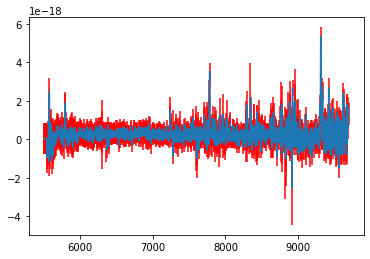

In [4]:
name = 'zCOSMOS-bright'
lambdas, fluxes, flux_errors = read_spec_file(name,
                                              spec_table[spec_table['name'] == name][3]['path'],
                                              zbright_errors, True)
plt.errorbar(lambdas, fluxes, flux_errors, ecolor='red', zorder=1)
plt.show()

In [290]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K

class VAE:
    
    def __init__(self, original_ndim, latent_ndim, intermediate_ndims):        
        # Build the encoder.
        original_input = Input(shape=(original_ndim,))
        prev_layer = original_input
        for intermediate_ndim in intermediate_ndims:
            prev_layer = Dense(intermediate_ndim, activation='relu')(prev_layer)
        latent_mean = Dense(latent_ndim)(prev_layer)
        latent_log_var = Dense(latent_ndim)(prev_layer)
        
        def sample_latent(args):
            # Sample from a normal distribution centered at latent_mean with
            # variance exp(latent_log_var).
            latent_mean, latent_log_var = args
            batch_size = K.shape(latent_mean)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_ndim))
            return latent_mean + K.exp(0.5 * latent_log_var) * epsilon
        
        latent_output = Lambda(sample_latent)([latent_mean, latent_log_var])
        self.encoder = Model(original_input,
                             [latent_mean, latent_log_var, latent_output])

        # Build the decoder.
        latent_input = Input(shape=(latent_ndim,))
        prev_layer = latent_input
        for intermediate_ndim in reversed(intermediate_ndims):
            prev_layer = Dense(intermediate_ndim, activation='relu')(prev_layer)
        original_output = Dense(original_ndim)(prev_layer)
        self.decoder = Model(latent_input, original_output)

        # Build the full auto-encoder.
        restored_input = self.decoder(self.encoder(original_input)[2])
        self.autoencoder = Model(original_input, restored_input)
        
        restoration_loss = mse(original_input, restored_input) * original_ndim
        kl_loss = -K.sum(1 + latent_log_var - K.square(latent_mean) -
                         K.exp(latent_log_var), axis=-1) / 2
        self.autoencoder.add_loss(K.mean(restoration_loss + kl_loss))
        
        self.autoencoder.compile(optimizer='adam')
        
        # Record that no training has occured yet.
        self.last_epoch = 0
        
    def train(self, training_data, validation_data, epochs, backup_name=None):
        self.last_epoch += epochs
        self.autoencoder.fit(training_data, epochs=self.last_epoch,
                             validation_data=(validation_data, None))
        if backup_name:
            self.autoencoder.save_weights(backup_name + '.h5')
        
    def load(self, backup_name):
        self.autoencoder.load_weights(backup_name + '.h5')
    
    def to_latent(self, original):
        return self.encoder.predict(original)[0]
    
    def from_latent(self, latent):
        return self.decoder.predict(latent)

################################################################################

# Visualize the 2D or 3D latent space.
def plot_results(vae, data, labels, filename=None):
    latent_data = vae.to_latent(data)
    fig = plt.figure(figsize=(12, 10))
    if latent_data.shape[1] == 2:
        ax = fig.gca()
    else:
        ax = fig.gca(projection='3d')
    p = ax.scatter(*latent_data.T, c=labels)
    fig.colorbar(p)
    if filename:
        fig.savefig(filename + '.png')
    plt.show()

################################################################################

split_index = int(0.8 * len(colors))

vae = VAE(len(bands), 2, [100, 10])
vae.train(colors[:split_index], colors[split_index:], 1, 'vae_cosmos')

has_specz = np.nan_to_num(speczs) > 0
plot_results(vae, colors[has_specz], speczs[has_specz])

Using TensorFlow backend.
W0712 16:51:59.461615 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 16:51:59.510530 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 16:51:59.538975 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 16:51:59.697676 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0712 16:52:00.111408 61144 deprecation_wrapper

Train on 257293 samples, validate on 64324 samples
Epoch 1/1
 72960/257293 [=======>......................] - ETA: 1:41:58 - loss: 78249744.000 - ETA: 37:00 - loss: 26898034.2708  - ETA: 23:34 - loss: 16235359.646 - ETA: 17:58 - loss: 11626747.066 - ETA: 14:44 - loss: 11607540.351 - ETA: 12:45 - loss: 9619133.165 - ETA: 11:21 - loss: 8142190.53 - ETA: 9:04 - loss: 6230568.3000 - ETA: 8:04 - loss: 5298189.445 - ETA: 7:18 - loss: 4608987.819 - ETA: 6:02 - loss: 3657973.586 - ETA: 4:55 - loss: 2870088.646 - ETA: 4:07 - loss: 2311110.556 - ETA: 3:42 - loss: 2007531.874 - ETA: 3:23 - loss: 1774723.962 - ETA: 3:16 - loss: 1664494.470 - ETA: 3:03 - loss: 1501424.439 - ETA: 2:49 - loss: 1350664.537 - ETA: 2:48 - loss: 1301648.535 - ETA: 2:43 - loss: 1227460.040 - ETA: 2:37 - loss: 1149142.277 - ETA: 2:41 - loss: 1125211.609 - ETA: 2:26 - loss: 1000377.838 - ETA: 2:21 - loss: 939633.952 - ETA: 2:13 - loss: 864723.59 - ETA: 2:07 - loss: 806881.65 - ETA: 2:06 - loss: 783626.99 - ETA: 2:04 - loss:

KeyboardInterrupt: 

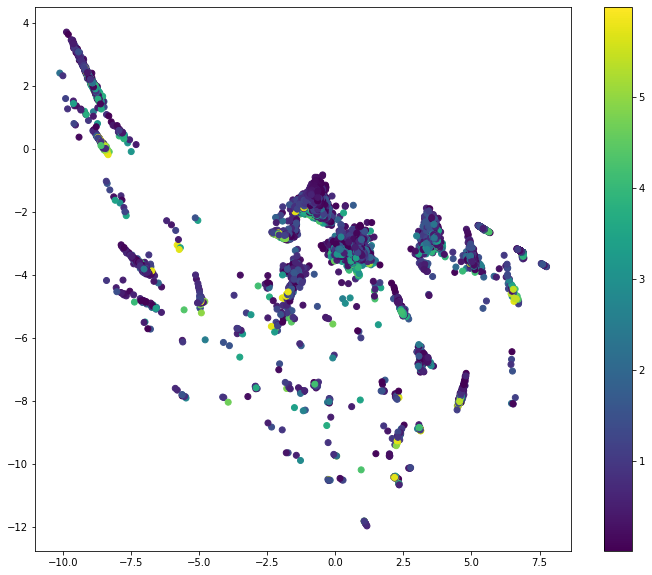

In [97]:
has_photozs= np.nan_to_num(photozs) > 0
plot_results(vae, colors[has_photozs], photozs[has_photozs])